# Analyse und Visualisierung: Kriminalität nach Nationalität

Dieses Notebook erstellt die Hauptgrafiken für das Paper. Es verarbeitet die vorbereiteten Daten aus den vorherigen Notebooks für die Daten (PKS, Justiz, Gefängnis, Bevölkerung) und berechnet Überrepräsentationsfaktoren.

**Erzeugte Plots:**
- PKS-Zeitreihe: Entwicklung des Faktors über alle Straftaten
- PKS gegenüber. Justiz: Vergleich Tatverdacht gegenüber Verurteilungen (ohne Ausländerrecht)
- Vergewaltigung: Spezifischer Delikt-Vergleich mit Bias-Hinweis
- Gefängnis: PKS-Verdacht gegenüber tatsächliche Inhaftierung
- Choroplethenkarte: Dominante Deliktkategorie pro Bundesland

Alle Grafiken werden als hochauflösende PNGs im `output/`-Ordner gespeichert.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(os.path.abspath(".."))
from src.config_local import get_spark_session
from pyspark.sql.functions import col, sum as _sum, lower, substring, trim, when, lit

spark = get_spark_session("Analyse_Blocks")

# Output-Verzeichnis für Plots
OUTPUT_DIR = "../output/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Style Config für Paper-Grafiken
FS_AXIS_LABEL = 22
FS_TICK_LABEL = 20
FS_LEGEND = 20
LINE_WIDTH = 4
MARKER_SIZE = 12

plt.rcParams.update({
    'font.size': 20,
    'font.family': 'sans-serif'
})

Starting local Spark: Analyse_Blocks


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/08 16:25:30 WARN Utils: Your hostname, MacBook-Pro-von-Justin-2.local, resolves to a loopback address: 127.0.0.1; using 192.168.178.184 instead (on interface en10)
26/02/08 16:25:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/08 16:25:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/08 16:25:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Vorverarbeitete Daten laden (aus 01/02 Notebooks)
df_pop = spark.read.parquet("../data/processed/population_clean.parquet")
df_pks = spark.read.parquet("../data/processed/pks_complete.parquet")
df_justiz = spark.read.parquet("../data/processed/justiz_clean.parquet")
df_pri = spark.read.parquet("../data/processed/prison_clean.parquet")

df_pop.show(3)

+----+-----------+---------+
|jahr|      pop_D|    pop_A|
+----+-----------+---------+
|1990| 7.417087E7|5582357.0|
|1977|5.7460519E7|3892226.0|
|2003|7.5189851E7|7341820.0|
+----+-----------+---------+
only showing top 3 rows


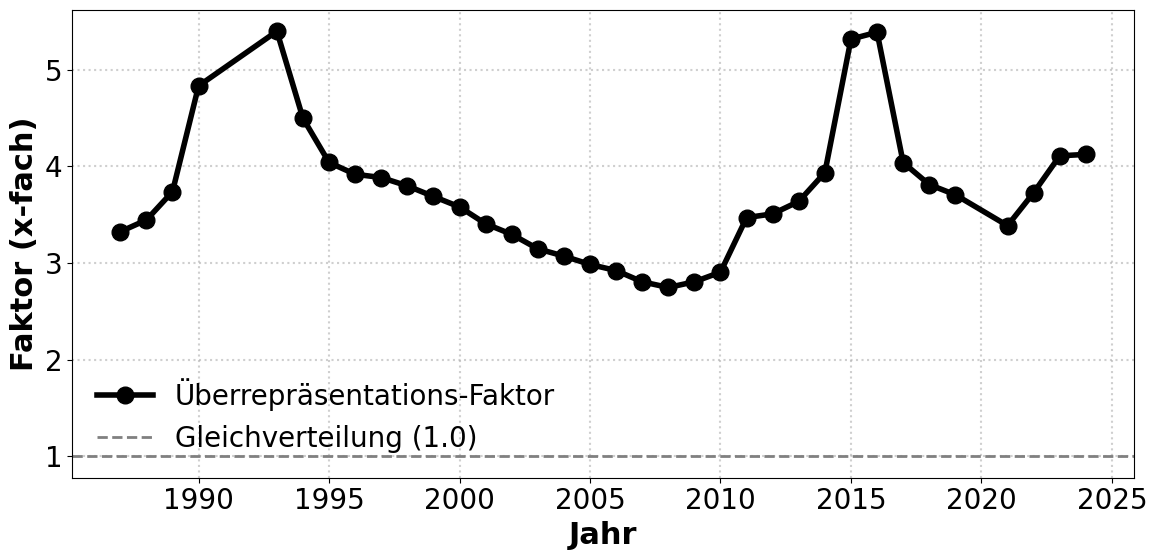

In [3]:
# PKS Aggregation: "Straftaten insgesamt" (exakt, um Doppelzählung zu vermeiden)
pks_agg = df_pks.filter(col("straftat") == "Straftaten insgesamt") \
    .groupBy("jahr").agg(
        _sum("anzahl_deutsch").alias("tat_D"),
        _sum("anzahl_nichtdeutsch").alias("tat_A")
    )

# Mit Bevölkerung joinen
df_1 = df_pop.join(pks_agg, on="jahr").toPandas().sort_values("jahr")

# Rate pro 100k Einwohner
df_1["rate_D"] = (df_1["tat_D"] / df_1["pop_D"]) * 100000
df_1["rate_A"] = (df_1["tat_A"] / df_1["pop_A"]) * 100000
df_1["faktor"] = df_1["rate_A"] / df_1["rate_D"]

# Plot
plt.figure(figsize=(12, 6))

plt.plot(df_1["jahr"], df_1["faktor"], 
         color="#000000", linestyle='-', linewidth=LINE_WIDTH, 
         marker='o', markersize=MARKER_SIZE,
         label="Überrepräsentations-Faktor")

plt.axhline(1.0, color="gray", linestyle="--", linewidth=2, label="Gleichverteilung (1.0)")

plt.xlabel("Jahr", fontsize=FS_AXIS_LABEL, fontweight='bold')
plt.ylabel("Faktor (x-fach)", fontsize=FS_AXIS_LABEL, fontweight='bold')
plt.xticks(fontsize=FS_TICK_LABEL)
plt.yticks(fontsize=FS_TICK_LABEL)
plt.grid(True, linestyle=':', alpha=0.6, linewidth=1.5)
plt.legend(fontsize=FS_LEGEND, frameon=False)
plt.tight_layout()

plt.savefig(OUTPUT_DIR + "pks_faktor_trend.png", dpi=300)
plt.show()

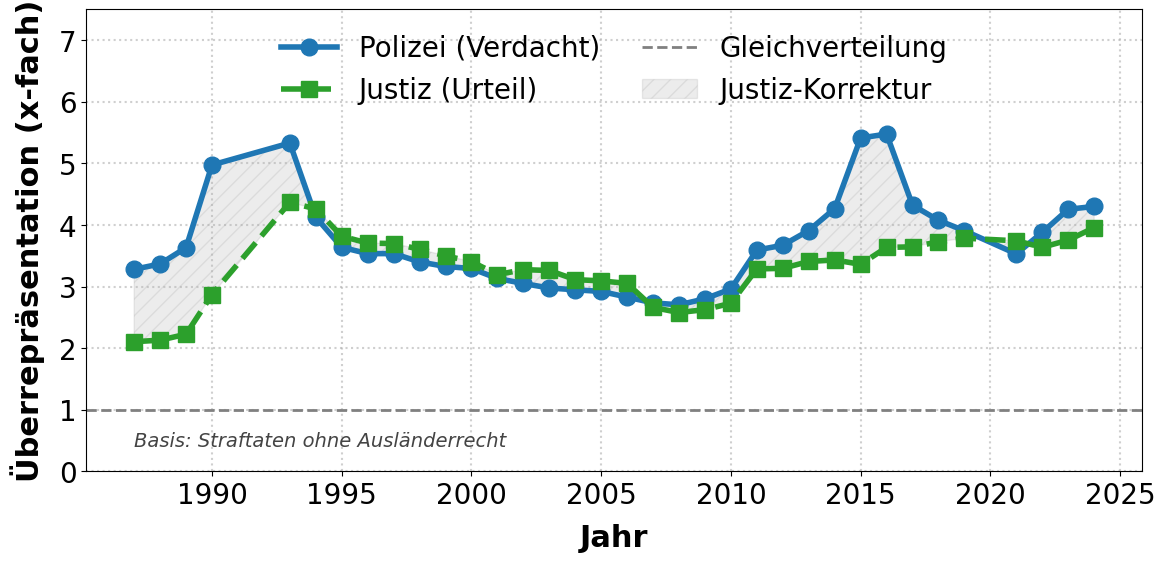

In [4]:
# Bereinigter Vergleich: PKS (Verdacht) vs. Justiz (Urteil)
# Filter: "insgesamt" OHNE Ausländerrecht (Aufenthalt, Asyl, Freizügigkeit)
FILTER_COND = (lower(col("straftat")).contains("insgesamt")) & \
              (~lower(col("straftat")).rlike("aufenthalt|asyl|freizüg"))

# PKS Aggregation (bereinigt)
pks_bereinigt = df_pks.filter(FILTER_COND).groupBy("jahr").agg(
    _sum("anzahl_deutsch").alias("pks_tat_D"),
    _sum("anzahl_nichtdeutsch").alias("pks_tat_A")
)

# Justiz Aggregation (bereinigt, nur Geschlecht=Insgesamt)
jus_bereinigt_A = df_justiz.filter(
    FILTER_COND & (col("geschlecht") == "Insgesamt") & (col("nationalitaet") == "Ausländer")
).groupBy("jahr").agg(_sum("verurteilte").alias("justiz_tat_A"))

jus_bereinigt_D = df_justiz.filter(
    FILTER_COND & (col("geschlecht") == "Insgesamt") & (col("nationalitaet") == "Deutsche")
).groupBy("jahr").agg(_sum("verurteilte").alias("justiz_tat_D"))

# Zusammenführen
df_all = df_pop.join(pks_bereinigt, "jahr") \
               .join(jus_bereinigt_A, "jahr") \
               .join(jus_bereinigt_D, "jahr")
pdf = df_all.toPandas().sort_values("jahr")

# Faktoren berechnen (Rate Ausländer / Rate Deutsche)
pdf["faktor_pks"] = (pdf["pks_tat_A"] / pdf["pop_A"]) / (pdf["pks_tat_D"] / pdf["pop_D"])
pdf["faktor_justiz"] = (pdf["justiz_tat_A"] / pdf["pop_A"]) / (pdf["justiz_tat_D"] / pdf["pop_D"])

# Plot
plt.figure(figsize=(12, 6))

plt.plot(pdf["jahr"], pdf["faktor_pks"], 
         label="Polizei (Verdacht)",
         color="#1f77b4", linewidth=LINE_WIDTH, marker='o', markersize=MARKER_SIZE)

plt.plot(pdf["jahr"], pdf["faktor_justiz"], 
         label="Justiz (Urteil)", 
         color="#2ca02c", linewidth=LINE_WIDTH, linestyle="--", marker='s', markersize=MARKER_SIZE)

plt.axhline(1.0, color="gray", linestyle="--", linewidth=2, label="Gleichverteilung")

plt.fill_between(pdf["jahr"], pdf["faktor_pks"], pdf["faktor_justiz"], 
                 color='gray', alpha=0.15, hatch='//', label="Justiz-Korrektur")

plt.xlabel("Jahr", fontsize=FS_AXIS_LABEL, fontweight='bold', labelpad=10)
plt.ylabel("Überrepräsentation (x-fach)", fontsize=FS_AXIS_LABEL, fontweight='bold', labelpad=10)
plt.ylim(0, 7.5)
plt.xticks(fontsize=FS_TICK_LABEL)
plt.yticks(fontsize=FS_TICK_LABEL)

plt.text(pdf["jahr"].min(), 0.5, 
         "Basis: Straftaten ohne Ausländerrecht", 
         fontsize=14, color='#444444', style='italic', va='center')

plt.legend(fontsize=FS_LEGEND, frameon=False, loc='upper center', ncol=2, columnspacing=1.5)
plt.grid(True, linestyle=':', alpha=0.6, linewidth=1.5)
plt.subplots_adjust(bottom=0.15, left=0.10, right=0.98, top=0.92)

plt.savefig(OUTPUT_DIR + "ueberrep_faktor_bereinigt.png", dpi=300, bbox_inches='tight')
plt.show()

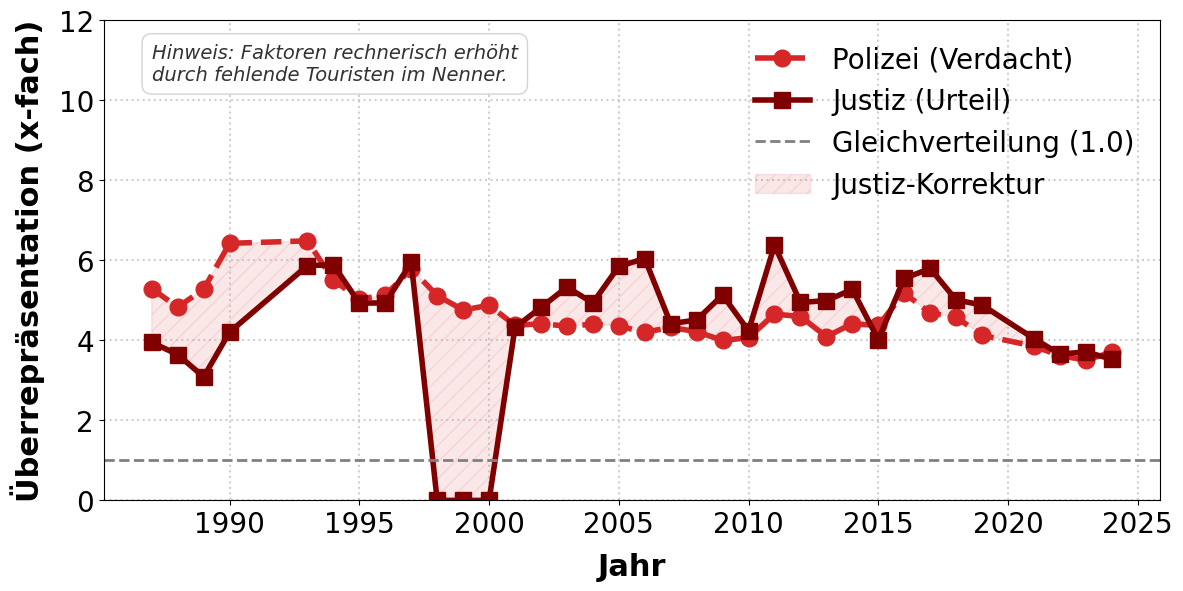

In [5]:
# Fokus-Analyse: Vergewaltigung (PKS vs. Justiz)
pks_rape = df_pks.filter(lower(col("straftat")).contains("vergewaltigung")) \
    .groupBy("jahr").agg(
        _sum("anzahl_deutsch").alias("tat_D"),
        _sum("anzahl_nichtdeutsch").alias("tat_A")
    )

justiz_rape = df_justiz.filter(
    (lower(col("straftat")).contains("vergewaltigung")) & 
    (col("geschlecht") == "Insgesamt") & 
    (col("nationalitaet").isin("Deutsche", "Ausländer"))
).groupBy("jahr").pivot("nationalitaet").sum("verurteilte") \
 .select(col("jahr"), col("Deutsche").alias("urt_D"), col("Ausländer").alias("urt_A"))

df_rape = df_pop.join(pks_rape, on="jahr", how="inner") \
                .join(justiz_rape, on="jahr", how="inner") \
                .toPandas().sort_values("jahr")

# Raten pro 100k
df_rape["rate_pks_D"] = (df_rape["tat_D"] / df_rape["pop_D"]) * 100000
df_rape["rate_pks_A"] = (df_rape["tat_A"] / df_rape["pop_A"]) * 100000
df_rape["rate_jus_D"] = (df_rape["urt_D"] / df_rape["pop_D"]) * 100000
df_rape["rate_jus_A"] = (df_rape["urt_A"] / df_rape["pop_A"]) * 100000

# Faktoren (Division durch 0 abfangen)
df_rape["faktor_pks"] = df_rape.apply(lambda x: x["rate_pks_A"] / x["rate_pks_D"] if x["rate_pks_D"] > 0 else 0, axis=1)
df_rape["faktor_jus"] = df_rape.apply(lambda x: x["rate_jus_A"] / x["rate_jus_D"] if x["rate_jus_D"] > 0 else 0, axis=1)

# Plot
plt.figure(figsize=(12, 6))

plt.plot(df_rape["jahr"], df_rape["faktor_pks"], 
         color="#d62728", linewidth=LINE_WIDTH, linestyle="--", marker='o', markersize=MARKER_SIZE,
         label="Polizei (Verdacht)")

plt.plot(df_rape["jahr"], df_rape["faktor_jus"], 
         color="#800000", linewidth=LINE_WIDTH, linestyle="-", marker='s', markersize=MARKER_SIZE,
         label="Justiz (Urteil)")

plt.axhline(1.0, color="gray", linestyle="--", linewidth=2, label="Gleichverteilung (1.0)")

plt.fill_between(df_rape["jahr"], df_rape["faktor_pks"], df_rape["faktor_jus"], 
                 color="#d62728", alpha=0.1, hatch='//', label="Justiz-Korrektur")

plt.xlabel("Jahr", fontsize=FS_AXIS_LABEL, fontweight='bold', labelpad=10)
plt.ylabel("Überrepräsentation (x-fach)", fontsize=FS_AXIS_LABEL, fontweight='bold', labelpad=10)
plt.ylim(0, 12)
plt.xticks(fontsize=FS_TICK_LABEL)
plt.yticks(fontsize=FS_TICK_LABEL)

plt.text(df_rape["jahr"].min(), 10.5, 
         "Hinweis: Faktoren rechnerisch erhöht\ndurch fehlende Touristen im Nenner.", 
         fontsize=14, color='#333333', style='italic', 
         bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.5'))

plt.legend(fontsize=FS_LEGEND, frameon=False, loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6, linewidth=1.5)
plt.subplots_adjust(bottom=0.15, left=0.10, right=0.98, top=0.95)

plt.savefig(OUTPUT_DIR + "vergewaltigung_bias_check.png", dpi=300, bbox_inches='tight')
plt.show()

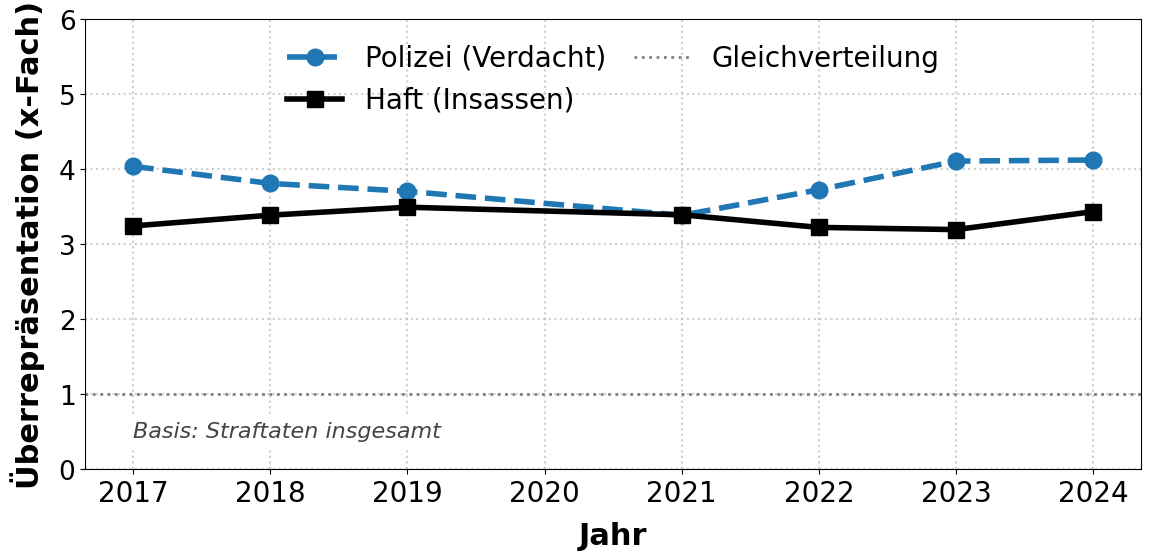

In [6]:
# Vergleich: PKS-Verdacht gegenüber Gefängnis-Insassen
pks_total = df_pks.filter(col("straftat") == "Straftaten insgesamt") \
    .groupBy("jahr").agg(
        _sum("anzahl_deutsch").alias("tat_D"),
        _sum("anzahl_nichtdeutsch").alias("tat_A")
    )

pri_agg = df_pri.groupBy("jahr").pivot("nationalitaet").sum("insassen") \
    .select(col("jahr"), col("Deutsche").alias("haft_D"), col("Ausländer").alias("haft_A"))

df_4 = df_pop.join(pks_total, on="jahr", how="inner") \
             .join(pri_agg, on="jahr", how="inner") \
             .toPandas().sort_values("jahr")

# Nur ab 2017 (vorher Zensus-Bruch / andere PKS-Methodik)
df_4 = df_4[df_4["jahr"] >= 2017].copy()

# Raten pro 100k
df_4["rate_pks_D"] = (df_4["tat_D"] / df_4["pop_D"]) * 100000
df_4["rate_pks_A"] = (df_4["tat_A"] / df_4["pop_A"]) * 100000
df_4["faktor_pks"] = df_4["rate_pks_A"] / df_4["rate_pks_D"]

df_4["rate_haft_D"] = (df_4["haft_D"] / df_4["pop_D"]) * 100000
df_4["rate_haft_A"] = (df_4["haft_A"] / df_4["pop_A"]) * 100000
df_4["faktor_haft"] = df_4["rate_haft_A"] / df_4["rate_haft_D"]

# Plot
plt.figure(figsize=(12, 6))

plt.plot(df_4["jahr"], df_4["faktor_pks"], 
         color="#1f77b4", linewidth=LINE_WIDTH, linestyle="--", marker="o", markersize=MARKER_SIZE,
         label="Polizei (Verdacht)")

plt.plot(df_4["jahr"], df_4["faktor_haft"], 
         color="black", linewidth=LINE_WIDTH, linestyle="-", marker="s", markersize=MARKER_SIZE,
         label="Haft (Insassen)")

plt.axhline(1.0, color="gray", linestyle=":", linewidth=2, label="Gleichverteilung")

plt.xlabel("Jahr", fontsize=FS_AXIS_LABEL, fontweight='bold', labelpad=10)
plt.ylabel("Überrepräsentation (x-Fach)", fontsize=FS_AXIS_LABEL, fontweight='bold', labelpad=10)

# X-Achse: Alle Jahre von 2017-2024 anzeigen
jahr_min = int(df_4["jahr"].min())
jahr_max = int(df_4["jahr"].max())
alle_jahre = list(range(jahr_min, jahr_max + 1))
plt.xticks(alle_jahre, fontsize=FS_TICK_LABEL)
plt.yticks(fontsize=19)
plt.ylim(0, 6)

plt.text(df_4["jahr"].min(), 0.5, 
         "Basis: Straftaten insgesamt", 
         fontsize=16, color='#444444', style='italic', 
         backgroundcolor='white', va='center')

plt.legend(fontsize=FS_LEGEND, frameon=False, loc='upper center', ncol=2, columnspacing=1.0)
plt.grid(True, linestyle=':', alpha=0.6, linewidth=1.5)
plt.subplots_adjust(bottom=0.15, left=0.10, right=0.98, top=0.90)

plt.savefig(OUTPUT_DIR + "prison_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

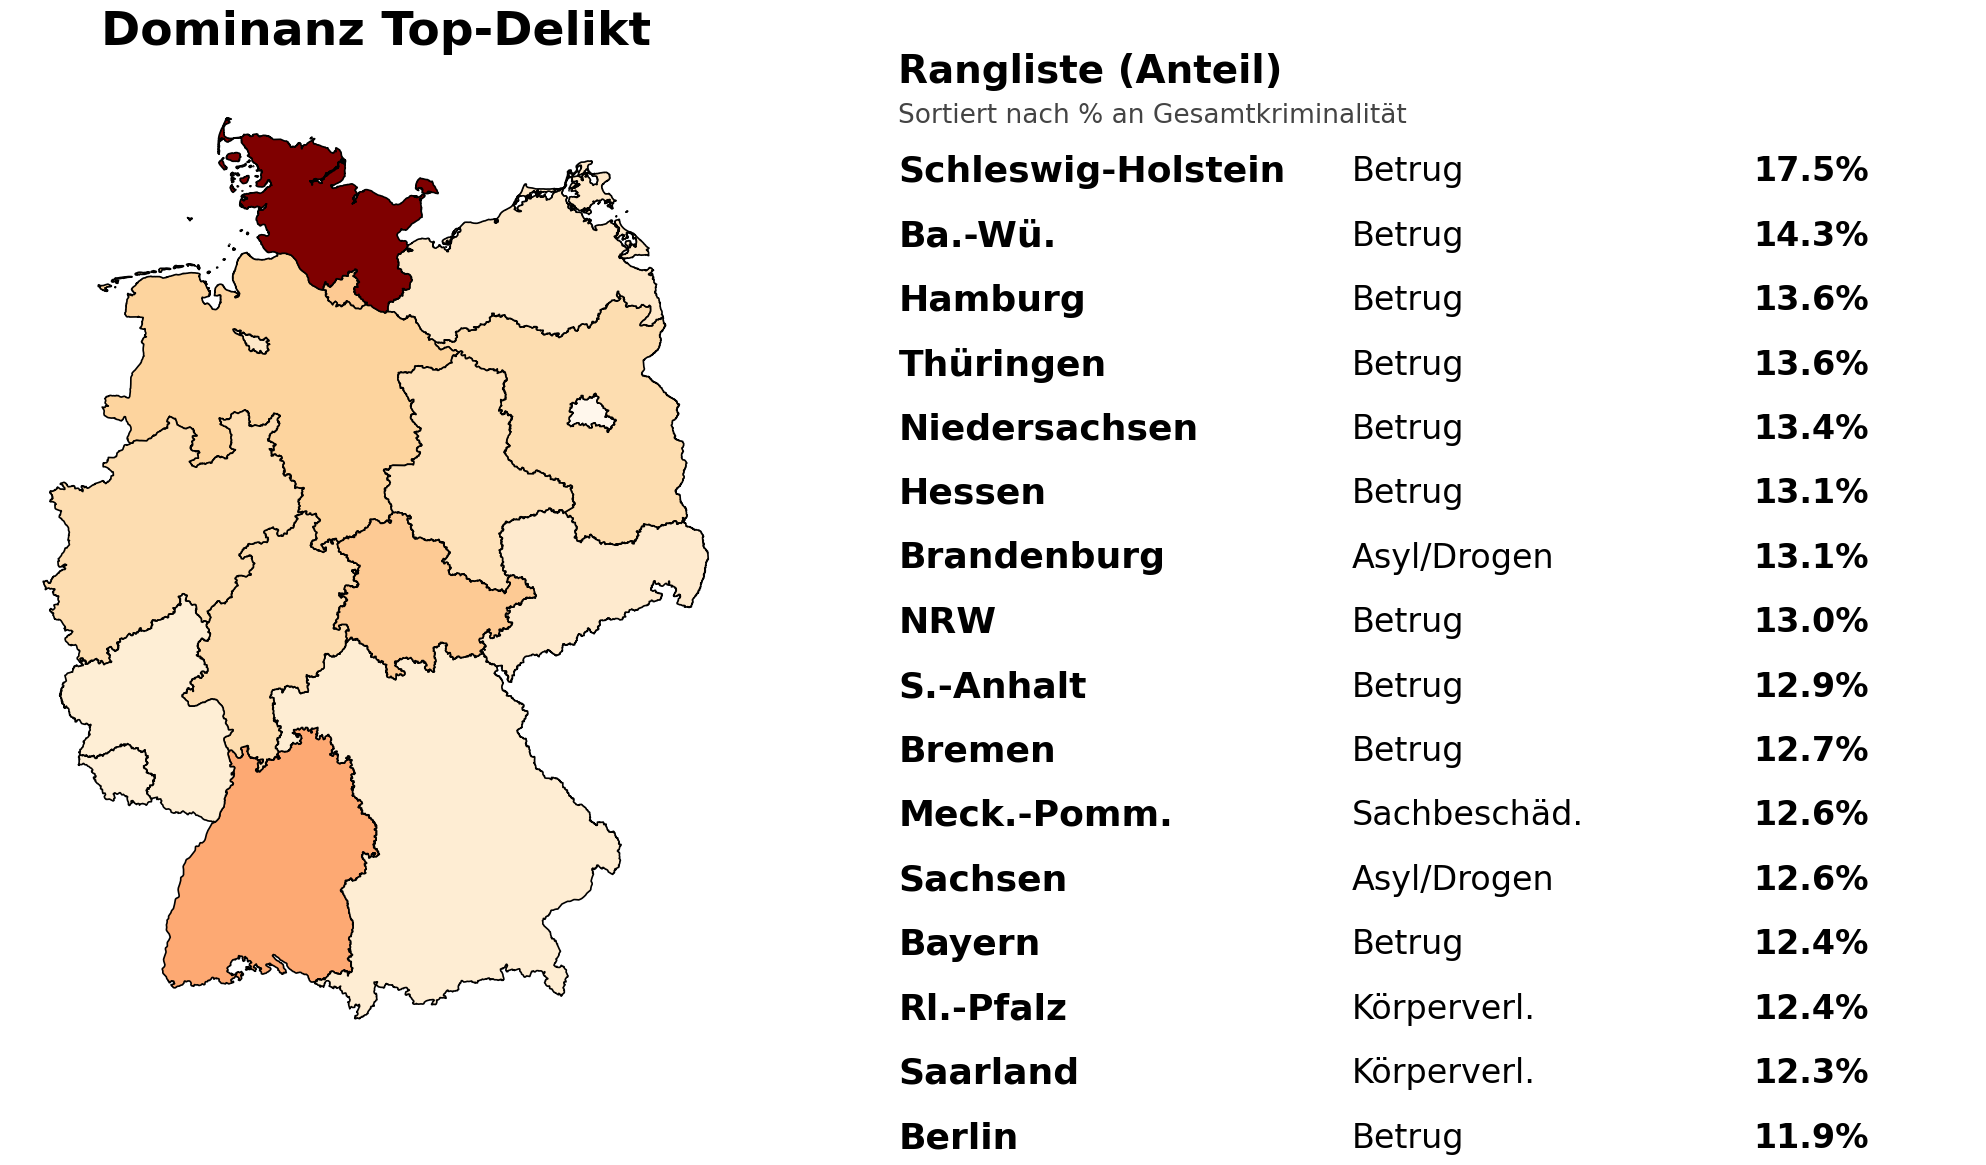

In [7]:
# Top-Delikt pro Bundesland
import matplotlib.patches as patches
import matplotlib.colors as mcolors

try:
    import geopandas as gpd
except ImportError:
    raise ImportError("geopandas wird für die Karte benötigt: pip install geopandas")

# Zusätzliche Font-Sizes für die Karte (braucht größere Schriften als Line-Plots)
FS_TITLE_MAIN = 34
FS_TITLE_SUB = 28
FS_BODY_BOLD = 26
FS_BODY_REG = 24
LINE_HEIGHT = 0.065

# Daten laden
FILENAME = "../data/raw/LA-F-01-T01-Laender-Faelle_xls.xlsx"
GEO_FILE = "../data/raw/bundeslaendergeo.json"

df = pd.read_excel(FILENAME, header=3)

# Bereinigung
if 'Schlüssel' in df.columns:
    df = df[df['Schlüssel'].notna()]
    df = df[df['Schlüssel'] != '------']
    df = df[~df['Schlüssel'].astype(str).str.contains("Schlüssel")]

for c in ['Anzahl erfasste Fälle', '%-Anteil an allen Fällen']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Oberkategorien und Wildcards rausfiltern
BLACKLIST = ['------', '890000', '****00', '3***00', '4***00', '600000', 
             '200000', '500000', '700000', '670000', '899000', '892000', '100000']

df_sub = df[~df['Schlüssel'].isin(BLACKLIST)].copy()
df_sub = df_sub[~df_sub['Schlüssel'].astype(str).str.contains(r'\*')]
df_sub = df_sub[df_sub['Bundesland'] != 'Bundesrepublik Deutschland']

# Top 1 Delikt pro Bundesland
top1_list = []
for state in df_sub['Bundesland'].dropna().unique():
    top1 = df_sub[df_sub['Bundesland'] == state] \
        .sort_values('%-Anteil an allen Fällen', ascending=False).iloc[0]
    top1_list.append(top1)

df_map_data = pd.DataFrame(top1_list)

def shorten_crime_name(name):
    name = str(name)
    if "Betrug" in name: return "Betrug"
    if "Körperverletzung" in name: return "Körperverl."
    if "Sachbeschädigung" in name: return "Sachbeschäd."
    if "Nebengesetze" in name: return "Asyl/Drogen"
    if "Aufenthalts" in name: return "Aufenthaltsr."
    if "Ladendiebstahl" in name: return "Ladendiebst."
    return name[:20] + "..."

df_map_data['Label'] = df_map_data['Straftat'].apply(shorten_crime_name)

# Geodaten mergen
gdf = gpd.read_file(GEO_FILE)
geo_col = next((c for c in ['NAME_1', 'name', 'GEN', 'lan_name', 'Bundesland'] if c in gdf.columns), None)
gdf_merged = gdf.merge(df_map_data, left_on=geo_col, right_on="Bundesland", how="left")

# Plot: Karte links, Rangliste rechts
fig, (ax_map, ax_text) = plt.subplots(1, 2, figsize=(22, 12), gridspec_kw={'width_ratios': [1, 1]})

CMAP = 'OrRd'
gdf_merged.plot(column='%-Anteil an allen Fällen', ax=ax_map, cmap=CMAP, 
                edgecolor='black', linewidth=1.2, legend=False)
ax_map.set_title("Dominanz Top-Delikt", fontsize=FS_TITLE_MAIN, pad=20, fontweight='bold')
ax_map.axis('off')

# Rangliste
ax_text.axis('off')
ax_text.text(0, 1.02, "Rangliste (Anteil)", fontsize=FS_TITLE_SUB, fontweight='bold', va='top')
ax_text.text(0, 0.97, "Sortiert nach % an Gesamtkriminalität", fontsize=int(FS_TITLE_SUB * 0.7), color='#444444', va='top')

sorted_data = gdf_merged.sort_values('%-Anteil an allen Fällen', ascending=False)
norm = mcolors.Normalize(vmin=gdf_merged['%-Anteil an allen Fällen'].min(), 
                         vmax=gdf_merged['%-Anteil an allen Fällen'].max())
mapper = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)

RENAME_MAP = {
    "Mecklenburg-Vorpommern": "Meck.-Pomm.", 
    "Nordrhein-Westfalen": "NRW",
    "Baden-Württemberg": "Ba.-Wü.",
    "Rheinland-Pfalz": "Rl.-Pfalz",
    "Sachsen-Anhalt": "S.-Anhalt"
}

y_pos = 0.90
for _, row in sorted_data.iterrows():
    if pd.isna(row['Label']): 
        continue
    
    color_val = mapper.to_rgba(row['%-Anteil an allen Fällen'])
    rect_size = 0.035
    rect = patches.Rectangle((-0.06, y_pos - rect_size/2 - 0.005), rect_size, rect_size, 
                             linewidth=1.5, edgecolor='black', facecolor=color_val)
    ax_text.add_patch(rect)
    
    state_name = RENAME_MAP.get(row[geo_col], row[geo_col])
    ax_text.text(0.00, y_pos, state_name, fontsize=FS_BODY_BOLD, fontweight='bold', va='center')
    ax_text.text(0.42, y_pos, row['Label'], fontsize=FS_BODY_REG, va='center')
    ax_text.text(0.90, y_pos, f"{row['%-Anteil an allen Fällen']:.1f}%", 
                 fontsize=FS_BODY_REG, fontweight='bold', va='center', ha='right')
    y_pos -= LINE_HEIGHT

plt.tight_layout()
plt.savefig(OUTPUT_DIR + "deutschland_map_top_delikt.png", dpi=300, bbox_inches='tight')
plt.show()